In [1]:
import os
import numpy as np
import pandas as pd
import datetime as dt
from scipy import stats
import sqlalchemy as db
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from pandas.tseries.offsets import *

np.seterr(divide = 'ignore')
pd.set_option('display.max_rows', 500)

In [2]:
load_dotenv()

# config and credentials
server = os.getenv('server')
database = os.getenv('database')
username = os.getenv('username')
password = os.getenv('password')

# connection
engine = db.create_engine(
    'mssql://{}:{}@{}/{}?driver=ODBC+Driver+18+for+SQL+Server'.format(
        username, password, server, database
    )
)

# establish connection
connection = engine.connect()

In [3]:
def get_sample_particulars(df):
    print('Number of observations: {:,}'.format(len(df.index)))
    print('Mean returns: {:.5f} | Std returns: {:.5f}'.format(df['R'].mean(), df['R'].std()))
    print('Volume sum: {:,}'.format(df['TDvolume'].sum()))
    print('Coupon mean: {:.5f}'.format(df['Coupon'].mean()))
    print('Yield mean: {:.5f}'.format(df['Yield'].mean()))

In [4]:
query = '''
    SELECT
        Date,
        Cusip,
        Coupon,
        Yield,
        TDvolume,
        RetEom / 100 AS R,
        RatingNum,
        RatingClass,
        CASE
            WHEN DATEDIFF(DAY, OfferingDate, Maturity) * 1.0 / 360 < 5 THEN 1
            WHEN DATEDIFF(DAY, OfferingDate, Maturity) * 1.0 / 360 < 15 THEN 2
            ELSE 3
        END AS MaturityBand
    FROM 
        BondReturns
'''

df = pd.read_sql(query, connection)
df.to_csv('data/output/bondReturns.csv', index=False)

df = pd.read_csv('data/output/bondReturns.csv')
df['Date'] = pd.to_datetime(df['Date'])

In [5]:
df.head()

,Date,Cusip,Coupon,Yield,TDvolume,R,RatingNum,RatingClass,MaturityBand
0,2002-07-31,000325AA8,8.875,7.731,46136898,NaN,14.0,1.HY,2
1,2002-08-31,000325AA8,8.875,7.933,6538150,0.005162,14.0,1.HY,2
2,2002-10-31,000325AA8,8.875,4.793,303375,NaN,14.0,1.HY,2
3,2002-11-30,000325AA8,8.875,6.790,1759188,-0.000199,14.0,1.HY,2
4,2002-12-31,000325AA8,8.875,8.437,500500,0.003678,14.0,1.HY,2


In [6]:
# number of entries
df['RatingClass'].value_counts(dropna=False)

0.IG    1441160
NaN      390044
1.HY     338608
Name: RatingClass, dtype: int64

In [7]:
# number of entries
df['MaturityBand'].value_counts(dropna=False)

2    1271724
3     552661
1     345427
Name: MaturityBand, dtype: int64

In [8]:
# number of distinct Cusips
df.groupby('MaturityBand', dropna=False).Cusip.nunique()

MaturityBand
1    65322
2    41670
3     6679
Name: Cusip, dtype: int64

In [9]:
# filtering
# df = df[df['MaturityBand'] == 1]
# df = df[df['TDvolume'] >= 5000000]
df = df[df['RatingClass'] == '0.IG']

get_sample_particulars(df)

Number of observations: 1,441,160
Mean returns: 0.00367 | Std returns: 0.03193
Volume sum: 70,029,475,626,294
Coupon mean: 4.99013
Yield mean: 3.76624


In [10]:
df['R'] = df['R'].fillna(0)

In [11]:
df.head()

,Date,Cusip,Coupon,Yield,TDvolume,R,RatingNum,RatingClass,MaturityBand
5,2002-07-31,000336AE7,6.875,7.061,57510,0.000000,8.0,0.IG,2
6,2002-08-31,000336AE7,6.875,7.369,118742,-0.008212,8.0,0.IG,2
7,2002-09-30,000336AE7,6.875,8.760,568962,-0.054690,8.0,0.IG,2
8,2002-10-31,000336AE7,6.875,7.767,11001450,0.052060,10.0,0.IG,2
9,2002-11-30,000336AE7,6.875,6.129,33498709,0.080880,10.0,0.IG,2


In [12]:
# df['logR'] = df['R']
df['logR'] = np.log(1 + df['R'])

In [13]:
df.head()

,Date,Cusip,Coupon,Yield,TDvolume,R,RatingNum,RatingClass,MaturityBand,logR
5,2002-07-31,000336AE7,6.875,7.061,57510,0.000000,8.0,0.IG,2,0.000000
6,2002-08-31,000336AE7,6.875,7.369,118742,-0.008212,8.0,0.IG,2,-0.008246
7,2002-09-30,000336AE7,6.875,8.760,568962,-0.054690,8.0,0.IG,2,-0.056242
8,2002-10-31,000336AE7,6.875,7.767,11001450,0.052060,10.0,0.IG,2,0.050750
9,2002-11-30,000336AE7,6.875,6.129,33498709,0.080880,10.0,0.IG,2,0.077776


In [14]:
J = 6 # formation period

df_ = df[
    ['Cusip', 'Date', 'R', 'logR']
].sort_values(['Cusip', 'Date']).set_index('Date')

cumr = df_.groupby(['Cusip'])['logR'].rolling(J, min_periods=J).sum().reset_index()
cumr = cumr.rename(columns = {'logR': 'SumLogR'})

cumr['CumRet'] = np.exp(cumr['SumLogR'])-1

In [15]:
cumr.tail(10)

,Cusip,Date,SumLogR,CumRet
1441150,G9213L860,2009-09-30,NaN,NaN
1441151,G9213L860,2009-10-31,NaN,NaN
1441152,G9213L860,2009-12-31,NaN,NaN
1441153,G9213L860,2010-03-31,NaN,NaN
1441154,G9213L860,2010-05-31,-0.022095,-0.021852
1441155,G9213L860,2010-07-31,-0.022095,-0.021852
1441156,G9213L860,2010-08-31,-0.036516,-0.035857
1441157,G9213L860,2010-10-31,-0.004065,-0.004057
1441158,G9213L860,2010-11-30,-0.002811,-0.002807
1441159,U9221AAZ1,2022-03-31,NaN,NaN


In [16]:
r = 10 # momentum ranking

cumr = cumr.dropna(axis=0, subset=['CumRet'])

cumr['MomR'] = cumr.groupby('Date')['CumRet'].transform(lambda x: pd.qcut(x, r, labels=False))
cumr['MomR'] = 1 + cumr['MomR'].astype(int)

In [17]:
cumr.head()

,Cusip,Date,SumLogR,CumRet,MomR
5,000336AE7,2002-12-31,0.003395,0.003401,1
6,000336AE7,2003-01-31,0.085399,0.089152,8
7,000336AE7,2003-03-31,0.093645,0.098170,9
8,000336AE7,2003-04-30,0.199087,0.220288,10
9,000336AE7,2003-05-31,0.150235,0.162107,9


In [18]:
cumr.groupby('MomR')['CumRet'].mean()

MomR
1    -0.050705
2    -0.015625
3    -0.003139
4     0.006680
5     0.015452
6     0.024204
7     0.033487
8     0.044983
9     0.061601
10    0.110534
Name: CumRet, dtype: float64

In [19]:
K = 6 # Holding Period Length: K can be between 3 to 12 months

cumr['form_date'] = cumr['Date']
cumr['medate'] = cumr['Date'] + MonthEnd(0)
cumr['hdate1'] = cumr['medate'] + MonthBegin(1)
cumr['hdate2'] = cumr['medate'] + MonthEnd(K)
cumr = cumr[['Cusip', 'form_date','MomR','hdate1','hdate2']]

In [20]:
cumr.head()

,Cusip,form_date,MomR,hdate1,hdate2
5,000336AE7,2002-12-31,1,2003-01-01,2003-06-30
6,000336AE7,2003-01-31,8,2003-02-01,2003-07-31
7,000336AE7,2003-03-31,9,2003-04-01,2003-09-30
8,000336AE7,2003-04-30,10,2003-05-01,2003-10-31
9,000336AE7,2003-05-31,9,2003-06-01,2003-11-30


In [21]:
port = pd.merge(df[['Cusip', 'Date', 'R']], cumr, on=['Cusip'], how='inner')
port = port[(port['hdate1'] <= port['Date']) & (port['Date'] <= port['hdate2'])]

port = port[['Cusip','form_date', 'MomR', 'hdate1','hdate2', 'Date', 'R']]

In [22]:
port.head()

,Cusip,form_date,MomR,hdate1,hdate2,Date,R
384,000336AE7,2002-12-31,1,2003-01-01,2003-06-30,2003-01-31,0.08546
448,000336AE7,2002-12-31,1,2003-01-01,2003-06-30,2003-03-31,0.00000
449,000336AE7,2003-01-31,8,2003-02-01,2003-07-31,2003-03-31,0.00000
512,000336AE7,2002-12-31,1,2003-01-01,2003-06-30,2003-04-30,0.05043
513,000336AE7,2003-01-31,8,2003-02-01,2003-07-31,2003-04-30,0.05043


In [23]:
port['Date'] = pd.to_datetime(port['Date'])

In [24]:
port.head()

,Cusip,form_date,MomR,hdate1,hdate2,Date,R
384,000336AE7,2002-12-31,1,2003-01-01,2003-06-30,2003-01-31,0.08546
448,000336AE7,2002-12-31,1,2003-01-01,2003-06-30,2003-03-31,0.00000
449,000336AE7,2003-01-31,8,2003-02-01,2003-07-31,2003-03-31,0.00000
512,000336AE7,2002-12-31,1,2003-01-01,2003-06-30,2003-04-30,0.05043
513,000336AE7,2003-01-31,8,2003-02-01,2003-07-31,2003-04-30,0.05043


In [25]:
cumr_port = port.groupby(['Date','MomR', 'form_date'])['R'].mean().reset_index()

start_yr = cumr_port['Date'].dt.year.min()+2
cumr_port = cumr_port.loc[cumr_port.Date.dt.year >= start_yr]
cumr_port = cumr_port.sort_values(by=['Date','MomR'])

In [26]:
cumr_port.head()

,Date,MomR,form_date,R
1290,2005-01-31,1,2004-07-31,0.013119
1291,2005-01-31,1,2004-08-31,0.006810
1292,2005-01-31,1,2004-09-30,0.007461
1293,2005-01-31,1,2004-10-31,0.003543
1294,2005-01-31,1,2004-11-30,0.004467


In [27]:
ewret = cumr_port.groupby(['Date','MomR'])['R'].mean().reset_index()
ewstd = cumr_port.groupby(['Date','MomR'])['R'].std().reset_index()

ewret = ewret.rename(columns={'R':'ewret'})
ewstd = ewstd.rename(columns={'R':'ewretstd'})

ewretdf = pd.merge(ewret, ewstd, on=['Date','MomR'], how='inner')
ewretdf = ewretdf.sort_values(by=['MomR', 'Date'])

In [28]:
ewretdf.head()

,Date,MomR,ewret,ewretstd
0,2005-01-31,1,0.007678,0.003654
10,2005-02-28,1,0.005016,0.002232
20,2005-03-31,1,-0.008037,0.003596
30,2005-04-30,1,0.005987,0.004417
40,2005-05-31,1,0.009233,0.007546


In [29]:
ewretdf.groupby(['MomR'])['ewret'].describe()[['count','mean', 'std']].reset_index()

,MomR,count,mean,std
0,1,213.0,0.006601,0.023783
1,2,213.0,0.003775,0.017394
2,3,213.0,0.003224,0.014704
3,4,213.0,0.003200,0.013351
4,5,213.0,0.003090,0.012639
5,6,213.0,0.003069,0.012628
6,7,213.0,0.003074,0.013138
7,8,213.0,0.003119,0.014715
8,9,213.0,0.003339,0.016315
9,10,213.0,0.003845,0.018867


In [30]:
ewret_t = ewretdf.pivot(index='Date', columns='MomR', values='ewret') 

# Add prefix port in front of each column 
ewret_t = ewret_t.add_prefix('port') 
ewret_t = ewret_t.rename(columns={'port1':'losers', 'port10':'winners'}) 
ewret_t['long_short'] = ewret_t.winners - ewret_t.losers

In [31]:
ewret_t.head()

MomR,losers,port2,port3,port4,port5,port6,port7,port8,port9,winners,long_short
Date,,,,,,,,,,,
2005-01-31,0.007678,0.004505,0.003334,0.003070,0.003500,0.005056,0.006760,0.009536,0.013936,0.018047,0.010369
2005-02-28,0.005016,0.000972,0.000208,-0.000379,-0.000751,-0.000422,-0.000609,0.000444,0.002236,0.004378,-0.000638
2005-03-31,-0.008037,-0.002141,-0.003597,-0.005778,-0.009145,-0.011548,-0.014032,-0.017192,-0.020996,-0.024713,-0.016676
2005-04-30,0.005987,0.006546,0.006306,0.006817,0.008087,0.008941,0.011490,0.014648,0.018804,0.020378,0.014392
2005-05-31,0.009233,0.005422,0.005308,0.005753,0.005820,0.007778,0.010124,0.010697,0.012414,0.014469,0.005235


In [32]:
ewret_t['cumret_winners'] = (1 + ewret_t.winners).cumprod() - 1 
ewret_t['cumret_losers'] = (1 + ewret_t.losers).cumprod() - 1
ewret_t['cumret_long_short'] = (1 + ewret_t.long_short).cumprod() - 1

In [33]:
mom_mean = ewret_t[['winners', 'losers', 'long_short']].mean().to_frame() 
mom_mean = mom_mean.rename(columns={0:'mean'}).reset_index() 
mom_mean

,MomR,mean
0,winners,0.003845
1,losers,0.006601
2,long_short,-0.002756


In [34]:
t_losers = pd.Series(stats.ttest_1samp(ewret_t['losers'], 0.0)).to_frame().T 
t_winners = pd.Series(stats.ttest_1samp(ewret_t['winners'], 0.0)).to_frame().T 
t_long_short = pd.Series(stats.ttest_1samp(ewret_t['long_short'], 0.0)).to_frame().T

t_losers['MomR'] = 'losers' 
t_winners['MomR'] = 'winners' 
t_long_short['MomR'] = 'long_short'

In [35]:
t_output = pd.concat([t_winners, t_losers, t_long_short]).rename(columns={0:'t-stat', 1:'p-value'}) 

# Combine mean, t and p and format output 
mom_output = pd.merge(mom_mean, t_output, on=['MomR'], how='inner')

mom_output['mean'] = mom_output['mean'].map('{:.2%}'.format) 
mom_output['t-stat'] = mom_output['t-stat'].map('{:.2f}'.format) 
mom_output['p-value'] = mom_output['p-value'].map('{:.2f}'.format) 

print('Momentum Strategy Summary:\n\n', mom_output)

Momentum Strategy Summary:

          MomR    mean t-stat p-value
0     winners   0.38%   2.97    0.00
1      losers   0.66%   4.05    0.00
2  long_short  -0.28%  -2.22    0.03


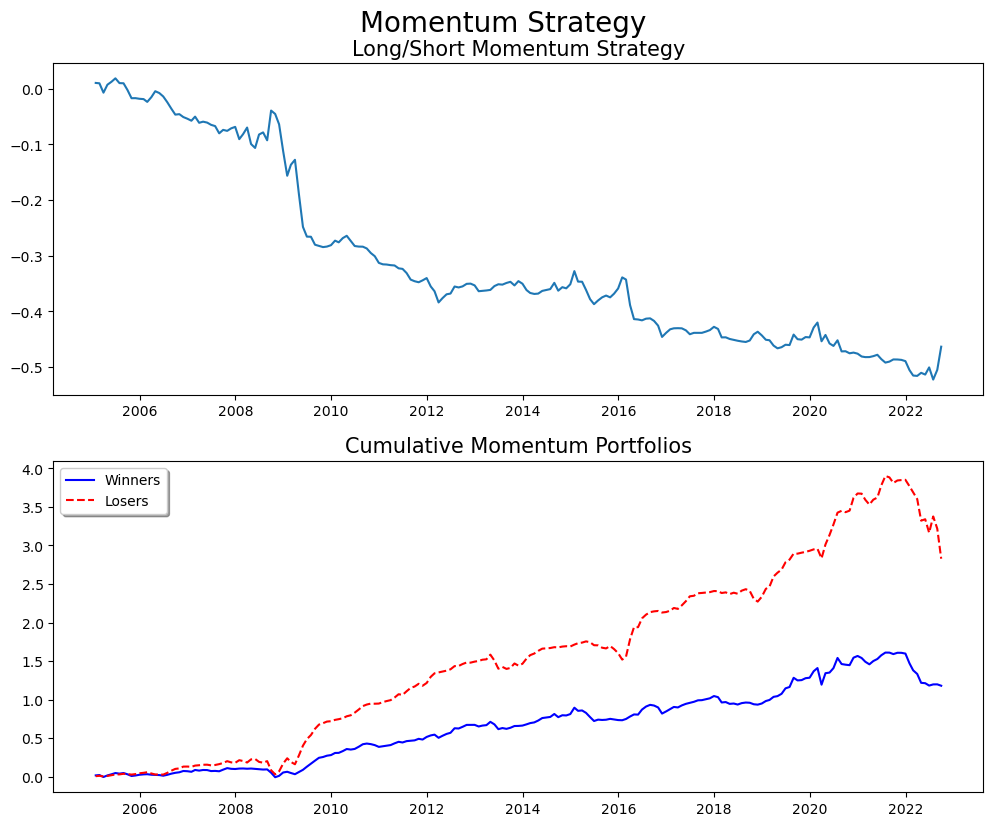

In [36]:
plt.figure(figsize=(12,9)) 
plt.suptitle('Momentum Strategy', fontsize=20) 

ax1 = plt.subplot(211) 
ax1.set_title('Long/Short Momentum Strategy', fontsize=15) 
ax1.plot(ewret_t['cumret_long_short']) 

ax2 = plt.subplot(212) 
ax2.set_title('Cumulative Momentum Portfolios', fontsize=15) 
ax2.plot(ewret_t['cumret_winners'], 'b-', ewret_t['cumret_losers'], 'r--') 
ax2.legend(('Winners','Losers'), loc='upper left', shadow=True) 

plt.subplots_adjust(top=0.92, hspace=0.2)